In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras import Input
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
# 1. Chargement des données
df = pd.read_parquet("C:/Users/lisas/Downloads/df_final_15min_NoNan_20250505.parquet", engine="fastparquet")
df["heure_arrondie"] = pd.to_datetime(df["heure_arrondie"])
df = df.sort_values("heure_arrondie")

In [35]:
# Découpage en train / test
df_train = df[df["heure_arrondie"] <= "2025-03-07"].copy()
df_test = df[df["heure_arrondie"] >= "2025-03-08"].copy()

# Ajout de features temporelles
for d in [df_train, df_test]:
    d["hour"] = d["heure_arrondie"].dt.hour
    d["weekday"] = d["heure_arrondie"].dt.dayofweek


In [36]:
# Normalisation
scaler_debit = MinMaxScaler()
scaler_hour = MinMaxScaler()
scaler_weekday = MinMaxScaler()

df_train["debit_scaled"] = scaler_debit.fit_transform(df_train[["debit"]])
df_test["debit_scaled"] = scaler_debit.transform(df_test[["debit"]])

df_train["hour_scaled"] = scaler_hour.fit_transform(df_train[["hour"]])
df_test["hour_scaled"] = scaler_hour.transform(df_test[["hour"]])

df_train["weekday_scaled"] = scaler_weekday.fit_transform(df_train[["weekday"]])
df_test["weekday_scaled"] = scaler_weekday.transform(df_test[["weekday"]])



In [37]:
def make_sequences_with_features(df, feature_cols, target_col='debit_scaled',
                                  time_col='heure_arrondie', id_col='nom_du_troncon', window_size=24):
    X, y, times, troncons = [], [], [], []
    for troncon, group in df.groupby(id_col):
        group = group.sort_values(time_col)
        feature_vals = group[feature_cols].values
        target_vals = group[target_col].values
        times_vals = group[time_col].values
        for i in range(len(group) - window_size):
            X.append(feature_vals[i:i+window_size])
            y.append(target_vals[i+window_size])
            times.append(times_vals[i+window_size])
            troncons.append(troncon)
    return np.array(X), np.array(y), times, troncons

In [38]:
features = ["debit_scaled", "hour_scaled", "weekday_scaled", "is_vacances", "is_ferie"]
window_size = 24

X_train, y_train, times_train, troncons_train = make_sequences_with_features(df_train, feature_cols=features, target_col='debit_scaled', window_size=window_size)
X_test, y_test, times_test, troncons_test = make_sequences_with_features(df_test, feature_cols=features, target_col='debit_scaled', window_size=window_size)


In [39]:
model = Sequential([
    Input(shape=(window_size, len(features))),
    LSTM(64, activation='tanh'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

In [40]:
# Entraînement 
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10
36233/36233 ━━━━━━━━━━━━━━━━━━━━ 340s 9ms/step - loss: 1.0887e-04 - val_loss: 8.9037e-05
Epoch 2/10
36233/36233 ━━━━━━━━━━━━━━━━━━━━ 321s 9ms/step - loss: 8.5314e-05 - val_loss: 8.8628e-05
Epoch 3/10
36233/36233 ━━━━━━━━━━━━━━━━━━━━ 329s 9ms/step - loss: 7.9590e-05 - val_loss: 8.7533e-05
Epoch 4/10
36233/36233 ━━━━━━━━━━━━━━━━━━━━ 381s 11ms/step - loss: 8.0206e-05 - val_loss: 8.4529e-05
Epoch 5/10
36233/36233 ━━━━━━━━━━━━━━━━━━━━ 387s 11ms/step - loss: 7.8157e-05 - val_loss: 8.6781e-05
Epoch 6/10
36233/36233 ━━━━━━━━━━━━━━━━━━━━ 388s 11ms/step - loss: 8.2175e-05 - val_loss: 8.3125e-05
Epoch 7/10
36233/36233 ━━━━━━━━━━━━━━━━━━━━ 387s 11ms/step - loss: 7.6424e-05 - val_loss: 8.3288e-05
Epoch 8/10
36233/36233 ━━━━━━━━━━━━━━━━━━━━ 383s 11ms/step - loss: 7.6242e-05 - val_loss: 8.3266e-05
Epoch 9/10
36233/36233 ━━━━━━━━━━━━━━━━━━━━ 391s 11ms/step - loss: 8.0023e-05 - val_loss: 8.2810e-05
Epoch 10/10
36233/36233 ━━━━━━━━━━━━━━━━━━━━ 388s 11ms/step - loss: 7.7862e-05 - val_loss: 8.6

In [46]:
# Prédictions
y_pred_scaled = model.predict(X_test)
y_pred = scaler_debit.inverse_transform(y_pred_scaled)
y_test_real = scaler_debit.inverse_transform(y_test.reshape(-1, 1))

15168/15168 ━━━━━━━━━━━━━━━━━━━━ 62s 4ms/step


In [47]:
# Résultats alignés
df_resultats = pd.DataFrame({
    'heure_arrondie': pd.to_datetime(times_test),
    'nom_du_troncon': troncons_test,
    'debit_reel': y_test_real.flatten(),
    'debit_pred': y_pred.flatten()
})

In [48]:
df_resultats.head(10)

,heure_arrondie,nom_du_troncon,debit_reel,debit_pred
0,2025-03-08 06:00:00,3 Continents I,120.0,141.229340
1,2025-03-08 06:15:00,3 Continents I,120.0,136.646332
2,2025-03-08 06:30:00,3 Continents I,120.0,140.866684
3,2025-03-08 06:45:00,3 Continents I,60.0,141.614410
4,2025-03-08 07:00:00,3 Continents I,60.0,84.411285
5,2025-03-08 07:15:00,3 Continents I,60.0,95.347519
6,2025-03-08 07:30:00,3 Continents I,150.0,83.257538
7,2025-03-08 07:45:00,3 Continents I,240.0,172.564835
8,2025-03-08 08:00:00,3 Continents I,210.0,237.674561
9,2025-03-08 08:15:00,3 Continents I,180.0,205.839844


In [49]:

# Évaluation
mae = mean_absolute_error(y_test_real, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_real, y_pred))
print(f"MAE : {mae:.2f} véhicules/h")
print(f"RMSE : {rmse:.2f} véhicules/h")

MAE : 76.48 véhicules/h
RMSE : 114.34 véhicules/h


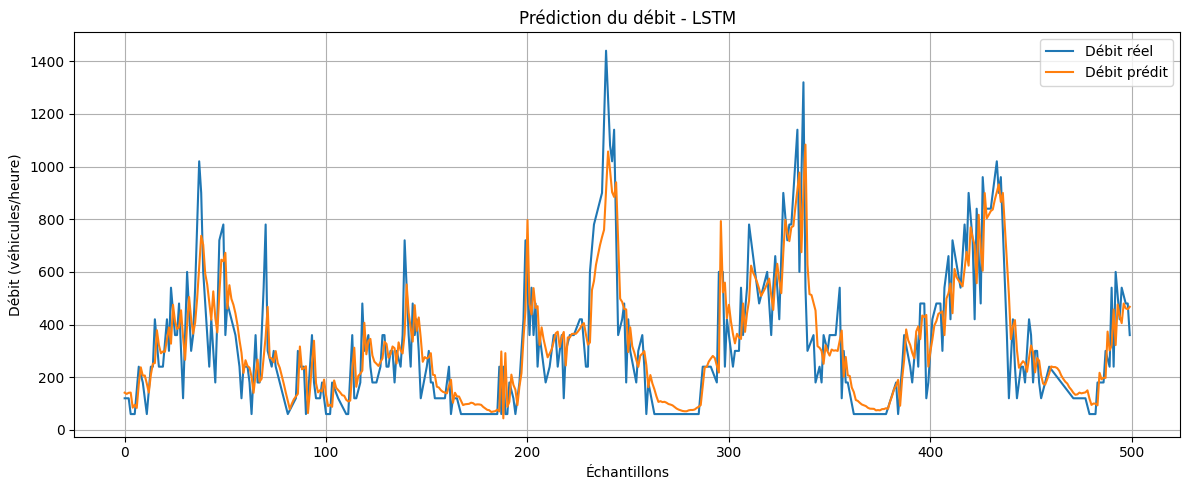

In [50]:
# Visualisation
plt.figure(figsize=(12, 5))
plt.plot(y_test_real[:500], label="Débit réel")
plt.plot(y_pred[:500], label="Débit prédit")
plt.title("Prédiction du débit - LSTM")
plt.xlabel("Échantillons")
plt.ylabel("Débit (véhicules/heure)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [51]:
df_resultats.to_csv("resultats_debit.csv", index=False)
